In [1]:
import sys
import os
import torch
from pathlib import Path
from torchvision.transforms import v2
import torchvision.datasets as datasets
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
sys.path.append('/zhome/ac/d/174101/thesis/src')
from utils.ResNet import ResNet
from utils.DenseNet import DenseNet
from utils.CombineChannels import Combined4ChannelsDataset

data_transforms = {
    'train': v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize([0.7306, 0.6204, 0.5511], [0.1087, 0.1948, 0.1759])
    ]),
    'test': v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize([0.7288, 0.6202, 0.5511], [0.1076, 0.1934, 0.1758])
    ]),
    'validation': v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_transforms_lbp = {
    'train': v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize([0.5791, 0.5791, 0.5791], [0.2315, 0.2315, 0.2315])
    ]),
    'test': v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize([0.5799, 0.5799, 0.5799], [0.2307, 0.2307, 0.2307])
    ]),
    'validation': v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Directories
base_path = '/work3/s220243/Thesis'
data_dir = Path(base_path) / 'data_split_resized'
data_dir_lbp = Path(base_path) / 'data_split_lbp'

model_name = "fungi_densenet264_4th_channel_B64_E1000_lr1.000e-04_SGD_CrossEntropy.pth" #specify a model
checkpoint_path = Path(base_path) / f"models/{model_name}" 

# Create the original datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['validation']}
image_datasets_lbp = {x: datasets.ImageFolder(os.path.join(data_dir_lbp, x), data_transforms_lbp[x]) for x in ['validation']}

# Create combined datasets
combined_datasets = {x: Combined4ChannelsDataset(image_datasets[x], image_datasets_lbp[x]) for x in ['validation']}

# Create data loaders
dataloaders = {x: torch.utils.data.DataLoader(combined_datasets[x], batch_size=1, shuffle=True, num_workers=0, pin_memory=True) for x in ['validation']}

# Load test data
dataset_sizes = {x: len(image_datasets_lbp[x]) for x in ['validation']}
print(dataset_sizes)

# Create a DataLoader for the datasets
val_loader = dataloaders['validation']

#train_class_names = image_datasets['train'].classes
val_class_names = image_datasets['validation'].classes

# Create a mapping dictionary
#class_mapping = {train_class_names[i]: i for i in range(len(train_class_names)) if train_class_names[i] in val_class_names}

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Load model
class_names = image_datasets_lbp['validation'].classes
num_classes = len(class_names)
# resnetX = (Num of channels, repetition, Bottleneck_expansion , Bottleneck_layer)
model_parameters={}
model_parameters['resnet18'] = ([64,128,256,512],[2,2,2,2],1,False)
model_parameters['resnet34'] = ([64,128,256,512],[3,4,6,3],1,False)
model_parameters['resnet50'] = ([64,128,256,512],[3,4,6,3],4,True)
model_parameters['resnet101'] = ([64,128,256,512],[3,4,23,3],4,True)
model_parameters['resnet152'] = ([64,128,256,512],[3,8,36,3],4,True)
# DensNetX
model_parameters['densenet121'] = [6,12,24,16]
model_parameters['densenet169'] = [6,12,32,32]
model_parameters['densenet201'] = [6,12,48,32]
model_parameters['densenet264'] = [6,12,64,48]

model = DenseNet(model_parameters['densenet264'] , in_channels=4, num_classes=num_classes) #specify architecture
model = model.to(device)
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the val_loader
for image, label in val_loader:
    image = image.to(device)
    label = label.to(device)

    # Perform inference
    with torch.no_grad():
        output = model(image)
        probabilities = torch.sigmoid(output)
        
        # Choose the class with the highest probability as the predicted label
        predicted_label = torch.argmax(probabilities, dim=1).item()
        #print(predicted_label)
        # Map the class to match the training set
        #mapped_label = class_mapping[val_loader.dataset.classes[label.item()]]
        #print(label.item())
        #print(mapped_label)

    # Append true labels and predicted labels to the lists
    #true_labels.append(mapped_label)
    true_labels.append(label.item())
    predicted_labels.append(predicted_label)

# Convert to numpy array
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

cpu
torch.Size([1, 256, 56, 56])
torch.Size([1, 1000])
cpu
{'validation': 1724}
cpu
Accuracy: 0.08584686774941995
Precision: 0.06830195522982418
Recall: 0.08564814814814814
F1 Score: 0.05398277787958366


/zhome/ac/d/174101/miniconda3/envs/fungi/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [2]:
predicted_labels

array([49, 40, 15, ..., 68, 49, 67])

In [3]:
true_labels

array([14, 12, 62, ..., 57, 44, 52])

In [8]:
probabilities[0,52]

tensor(0.0834)

In [6]:
for image, label in val_loader:
    print(image.shape)
    print(label)
    break

torch.Size([1, 4, 224, 224])
tensor([44])


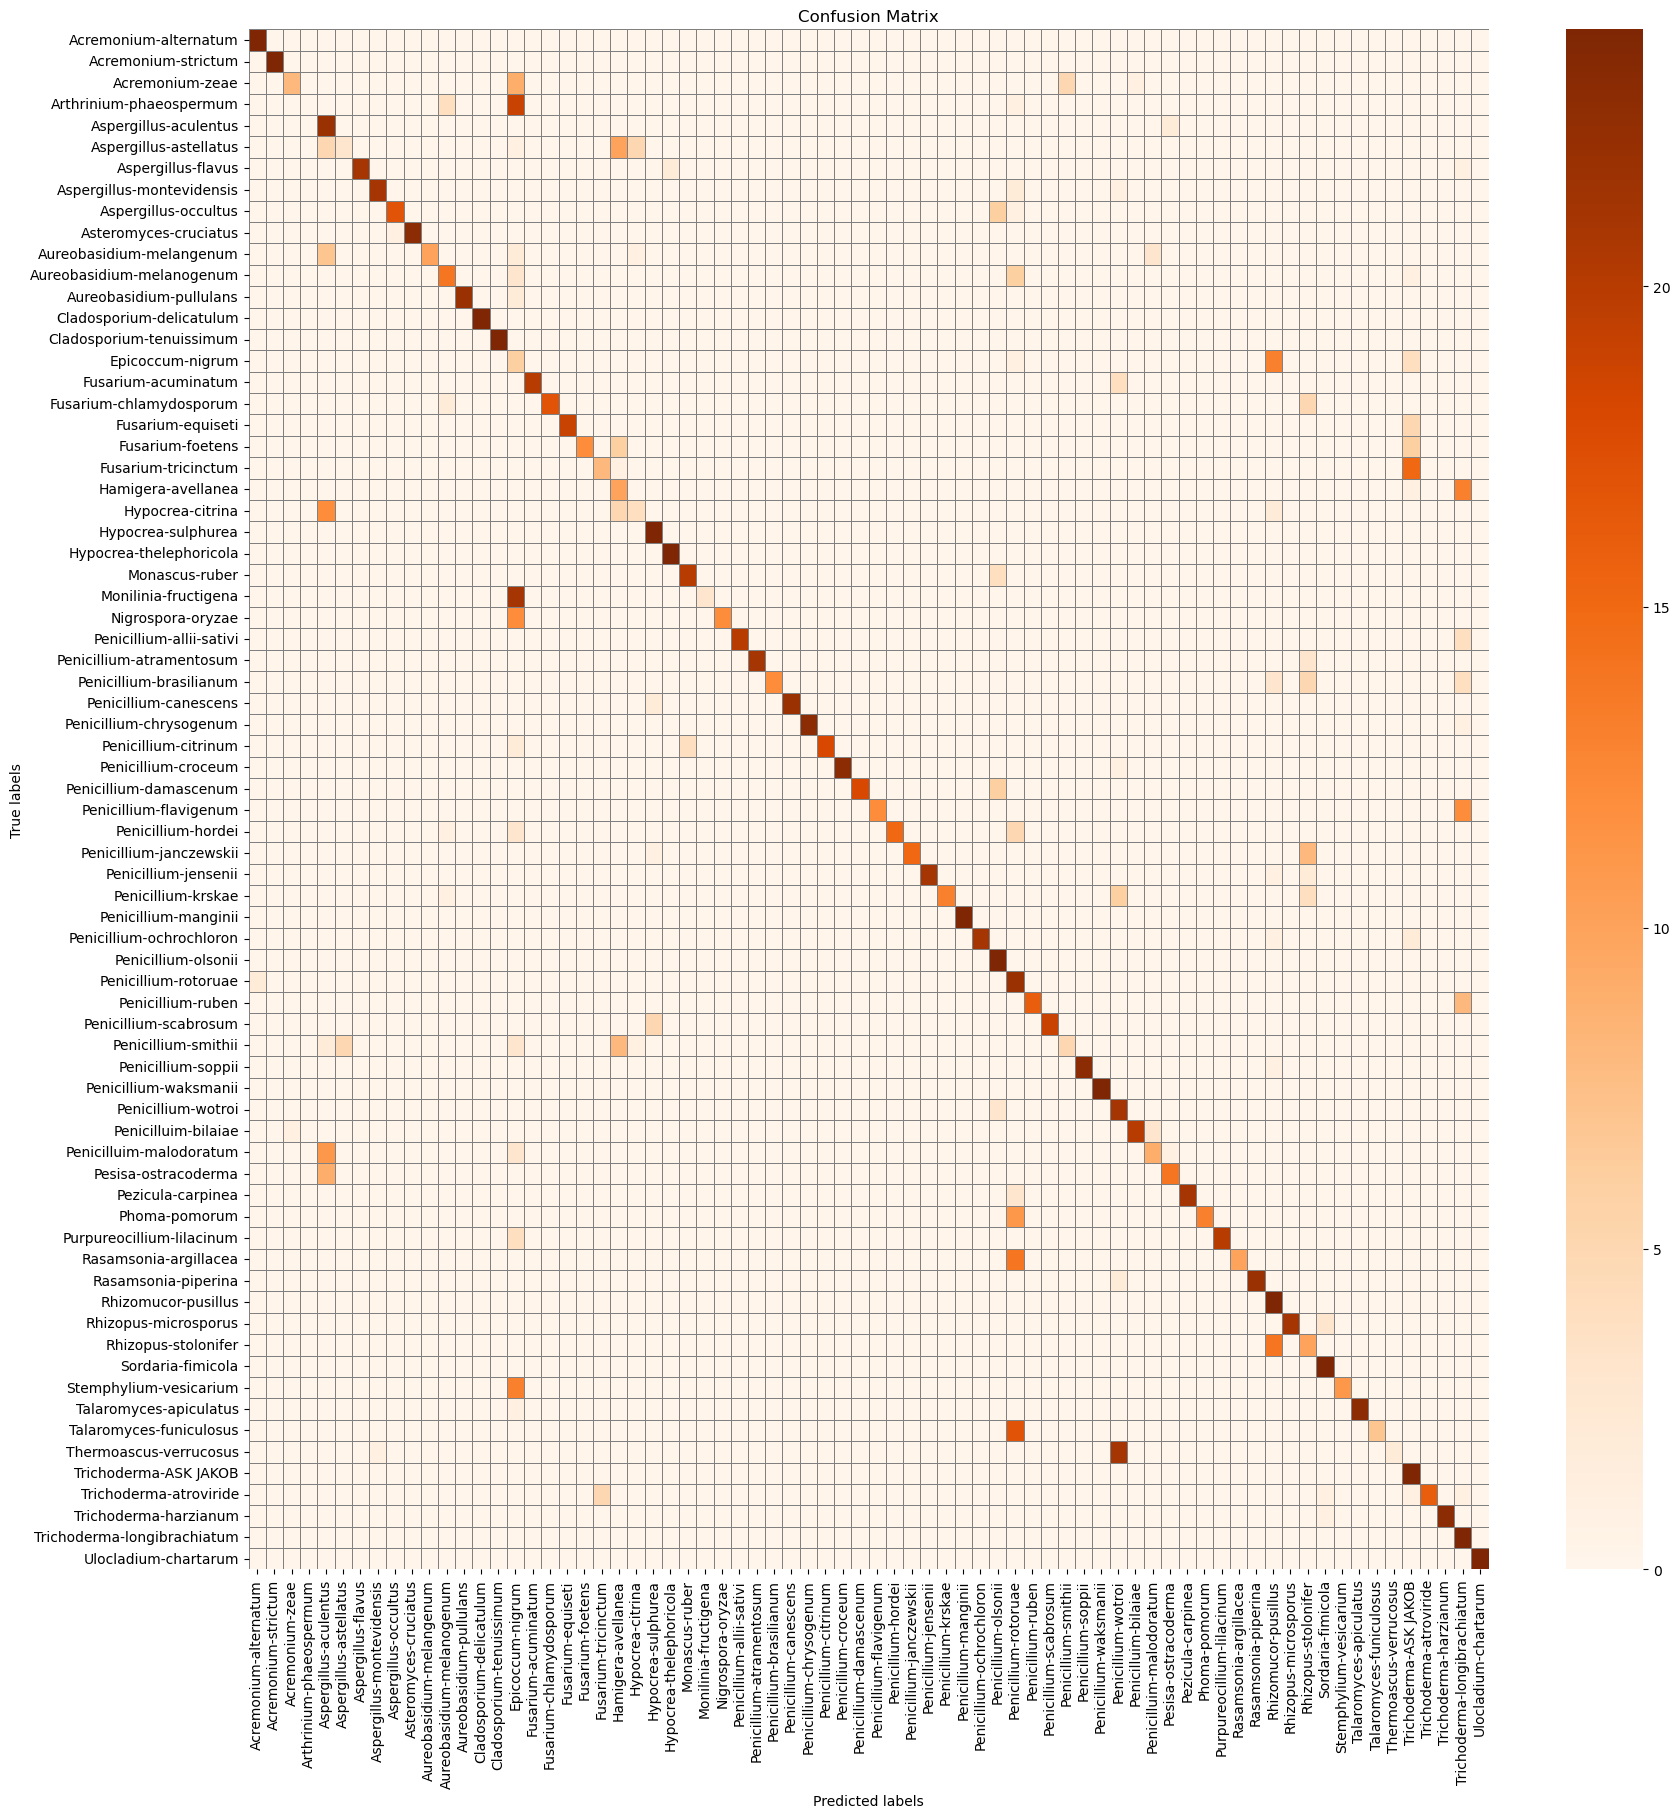

In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix, annot=False, fmt="d", cmap="Oranges", xticklabels=class_names, yticklabels=class_names, linewidths=0.5, linecolor='gray')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig(f'/zhome/ac/d/174101/thesis/plots/Conf_matrix_{model_name}.png')
